In [158]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_qrc_rewards(pt_file="../data/qrc_reward_seeds.pt", name="QRC"):
    data = torch.load(pt_file)
    all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)

    # Ensure 2D shape
    if all_rewards.ndim == 1:
        all_rewards = all_rewards.reshape(1, -1)

    num_seeds, num_episodes = all_rewards.shape
    print("num_seeds :", num_seeds)
    print("num_episodes :", num_episodes)

    # Compute mean and std across seeds
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)

    episodes = np.arange(1, num_episodes + 1)

    # 90% confidence interval
    ci_90 = 1.645 * (std_rewards / np.sqrt(num_seeds))
    plt.figure(figsize=(12,6))
    sns.lineplot(x=episodes, y=mean_rewards, label="Mean Reward", color="blue")
    plt.fill_between(episodes, mean_rewards - ci_90, mean_rewards + ci_90,
                    alpha=0.3, color="blue", label="90% CI")
    plt.title(f"{name} Training Rewards seeds 0-{num_seeds}, 90% CI")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 95% confidence interval
    ci_95 = 1.96 * (std_rewards / np.sqrt(num_seeds))
    plt.figure(figsize=(14,6))
    sns.lineplot(x=episodes, y=mean_rewards, label="Mean Reward", color="red")
    plt.fill_between(episodes, mean_rewards - ci_95, mean_rewards + ci_95,
                    alpha=0.3, color="red", label="95% CI")
    plt.title(f"{name} Training Rewards seeds 0-{num_seeds}, 95% CI")
    plt.xlabel("Episode")
    plt.ylabel("Return per Episode")
    plt.grid(True)
    plt.legend()
    plt.show()

def load_reward_file(pt_file):
    data = torch.load(pt_file)
    rewards = np.array(data['rewards'])

    if rewards.ndim == 1:
        rewards = rewards.reshape(1, -1)

    num_seeds, num_episodes = rewards.shape
    mean_rewards = rewards.mean(axis=0)
    std_rewards = rewards.std(axis=0)
    ci_95 = 1.96 * (std_rewards / np.sqrt(num_seeds))  # 95% CI

    return mean_rewards, ci_95, num_episodes, num_seeds


def plot_graph(qrc_file=None, dqn_file=None, qrc_name="QRC", dqn_name="DQN", graph_title="Training Reward Comparison"):
    plt.figure(figsize=(14, 7))

    # ---- Plot QRC ----
    if qrc_file is not None:
        qrc_mean, qrc_ci, qrc_len, qrc_seeds = load_reward_file(qrc_file)
        episodes = np.arange(1, qrc_len + 1)
        print("QRC seeds :", qrc_seeds)
        

        sns.lineplot(x=episodes, y=qrc_mean, label=qrc_name, color="red")
        # plt.fill_between(episodes, qrc_mean - qrc_ci, qrc_mean + qrc_ci, color="red",
        #                  alpha=0.25, label=f"{qrc_name} 95% CI")

    # ---- Plot DQN ----
    if dqn_file is not None:
        dqn_mean, dqn_ci, dqn_len, dqn_seeds = load_reward_file(dqn_file)
        episodes = np.arange(1, dqn_len + 1)
        print("DQN seeds :", dqn_seeds)

        sns.lineplot(x=episodes, y=dqn_mean, label=dqn_name, color="blue")
        # plt.fill_between(episodes, dqn_mean - dqn_ci, dqn_mean + dqn_ci, color="blue",
        #                  alpha=0.25, label=f"{dqn_name} 95% CI")

    plt.title(graph_title)
    plt.xlabel("Episode")
    plt.ylabel("Return per Episode")
    plt.grid(True)
    plt.legend()
    plt.show()


def load_all_rewards(folder="results_qrc"):
    """Load all txt reward files from folder and return a 2D NumPy array (seeds x episodes)"""
    all_files = sorted([f for f in os.listdir(folder) if f.endswith(".txt")])
    rewards_list = []

    for index, file in enumerate(all_files):
        
        file_path = os.path.join(folder, file)
        rewards = np.loadtxt(file_path)
        # Ensure 1D array
        rewards = rewards.reshape(-1)
        rewards_list.append(rewards)

    all_rewards = np.stack(rewards_list, axis=0)  # shape: (num_seeds, num_episodes)
    return all_rewards

def plot_rewards_from_folder(folder="results_qrc", name="QRC"):
    all_rewards = load_all_rewards(folder)
    num_seeds, num_episodes = all_rewards.shape
    print(f"Loaded rewards: {num_seeds} seeds, {num_episodes} episodes each.")

    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)

    episodes = np.arange(1, num_episodes + 1)

    # 90% CI
    ci_90 = 1.645 * (std_rewards / np.sqrt(num_seeds))
    plt.figure(figsize=(12,6))
    sns.lineplot(x=episodes, y=mean_rewards, label="Mean Reward", color="blue")
    plt.fill_between(episodes, mean_rewards - ci_90, mean_rewards + ci_90,
                     alpha=0.3, color="blue", label="90% CI")
    plt.title(f"{name} Training Rewards (90% CI)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 95% CI
    ci_95 = 1.96 * (std_rewards / np.sqrt(num_seeds))
    plt.figure(figsize=(12,6))
    sns.lineplot(x=episodes, y=mean_rewards, label="Mean Reward", color="red")
    plt.fill_between(episodes, mean_rewards - ci_95, mean_rewards + ci_95,
                     alpha=0.3, color="red", label="95% CI")
    plt.title(f"{name} Training Rewards (95% CI) : Seed {num_seeds}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_multiple_rewards(folders, names, ci=0.95, title="Training Rewards Comparison"):
    """
    Plot mean rewards with CI for multiple folders on the same graph.
    
    folders : list of folder paths
    names   : list of names corresponding to folders
    ci      : confidence interval (0.9 or 0.95)
    """
    assert len(folders) == len(names), "folders and names must have same length"

    plt.figure(figsize=(14,7))

    for folder, name in zip(folders, names):
        all_rewards = load_all_rewards(folder)
        num_seeds, num_episodes = all_rewards.shape

        mean_rewards = np.mean(all_rewards, axis=0)
        std_rewards = np.std(all_rewards, axis=0)
        episodes = np.arange(1, num_episodes + 1)

        if ci == 0.90:
            ci_multiplier = 1.645
        elif ci == 0.95:
            ci_multiplier = 1.96
        else:
            raise ValueError("CI must be 0.90 or 0.95")

        ci_values = ci_multiplier * (std_rewards / np.sqrt(num_seeds))

        sns.lineplot(x=episodes, y=mean_rewards, label=name)
        plt.fill_between(episodes, mean_rewards - ci_values, mean_rewards + ci_values,
                         alpha=0.3)

        print(f"[{name}] Seeds: {num_seeds}, Episodes: {num_episodes}")

    plt.title(f"{title} ({int(ci*100)}% CI)")
    plt.xlabel("Episode")
    plt.ylabel("Return per Episode")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_multiple_rewards_smooth(folders, names, ci=0.95, title="Training Rewards Comparison", smooth_window=10):
    """
    Plot mean rewards with CI for multiple folders on the same graph with optional smoothing.
    
    folders       : list of folder paths
    names         : list of names corresponding to folders
    ci            : confidence interval (0.9 or 0.95)
    smooth_window : window size for moving average smoothing
    """
    assert len(folders) == len(names), "folders and names must have same length"

    plt.figure(figsize=(14,7))

    for folder, name in zip(folders, names):
        all_rewards = load_all_rewards(folder)
        num_seeds, num_episodes = all_rewards.shape

        mean_rewards = np.mean(all_rewards, axis=0)
        std_rewards = np.std(all_rewards, axis=0)

        # Apply simple moving average for smoothing
        if smooth_window > 1:
            mean_rewards = np.convolve(mean_rewards, np.ones(smooth_window)/smooth_window, mode='same')

        episodes = np.arange(1, num_episodes + 1)

        if ci == 0.90:
            ci_multiplier = 1.645
        elif ci == 0.95:
            ci_multiplier = 1.96
        else:
            raise ValueError("CI must be 0.90 or 0.95")

        ci_values = ci_multiplier * (std_rewards / np.sqrt(num_seeds))

        sns.lineplot(x=episodes, y=mean_rewards, label=name)
        # plt.fill_between(episodes, mean_rewards - ci_values, mean_rewards + ci_values,
        #                  alpha=0.3)

        print(f"[{name}] Seeds: {num_seeds}, Episodes: {num_episodes}")

    plt.title(f"{title} ({int(ci*100)}% CI)")
    plt.xlabel("Episode")
    plt.ylabel("Return per Episode")
    plt.grid(True)
    plt.legend()
    plt.show()
    



num_seeds : 250
num_episodes : 1000


/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)


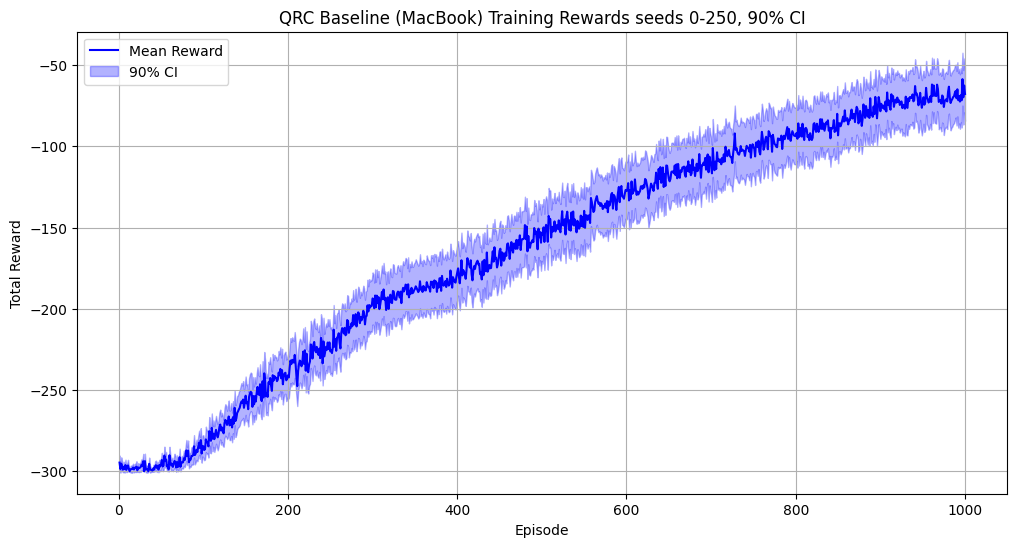

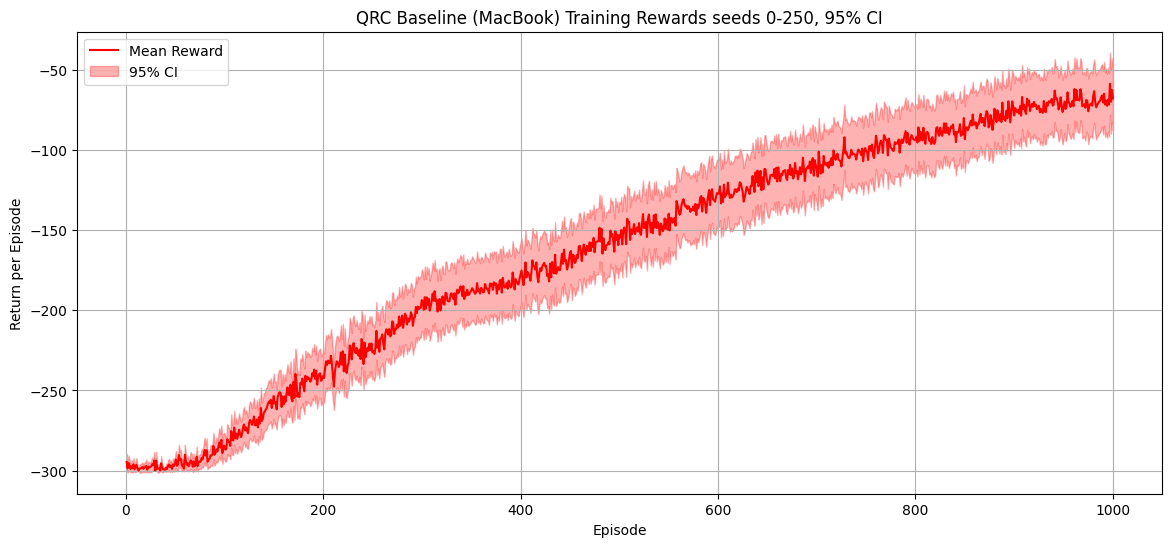

/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)


num_seeds : 210
num_episodes : 1000


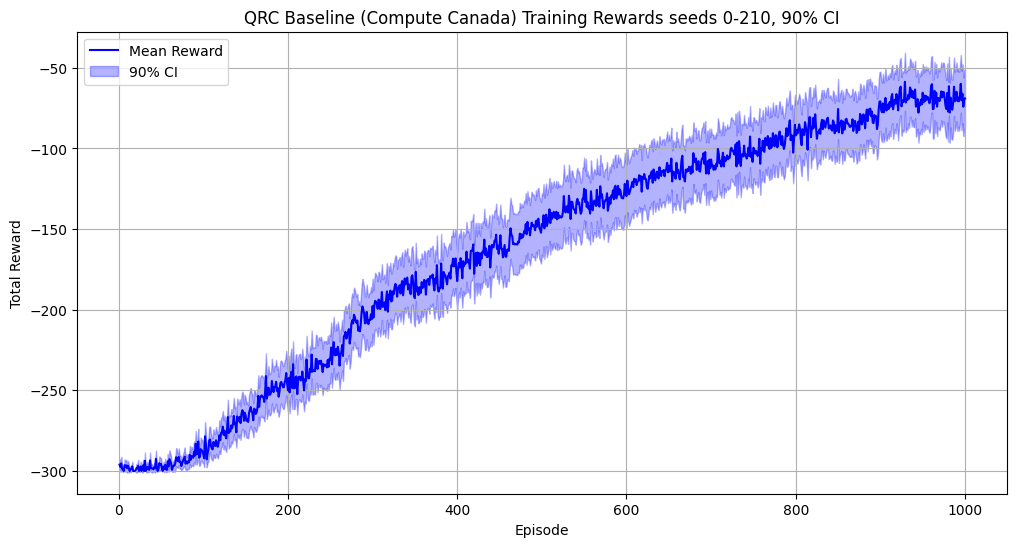

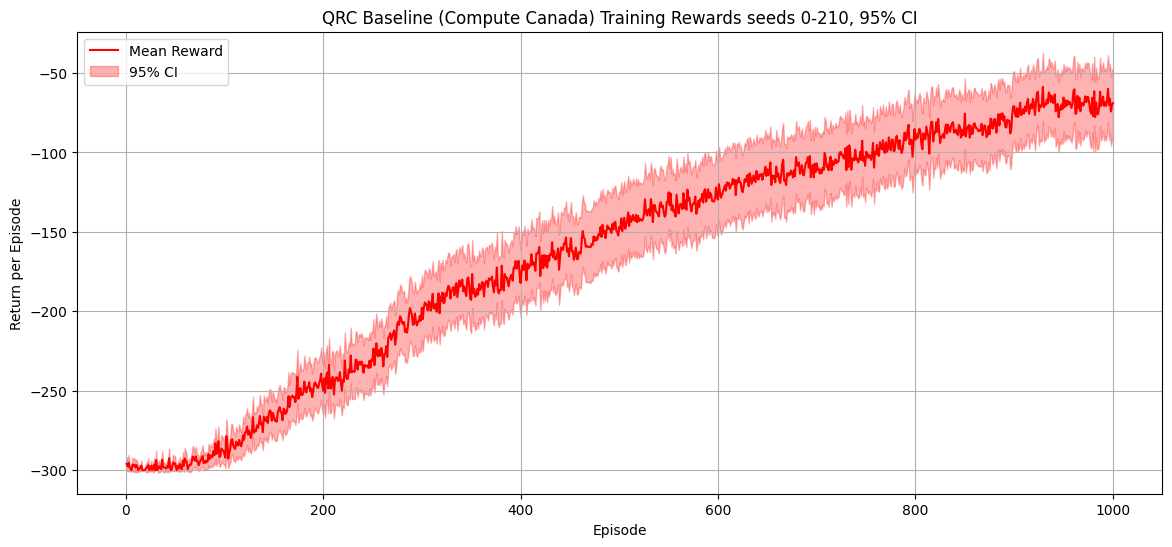

/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)


num_seeds : 251
num_episodes : 1000


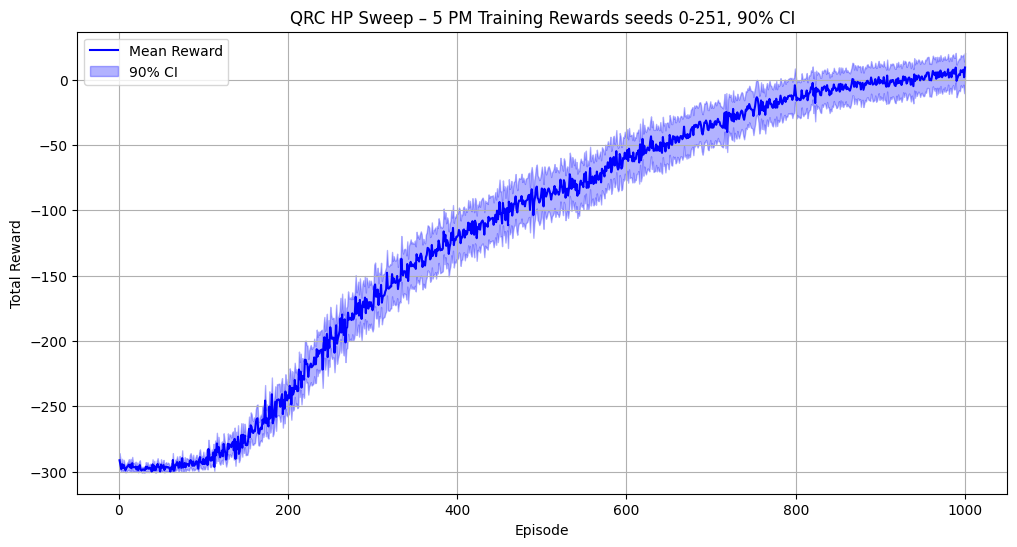

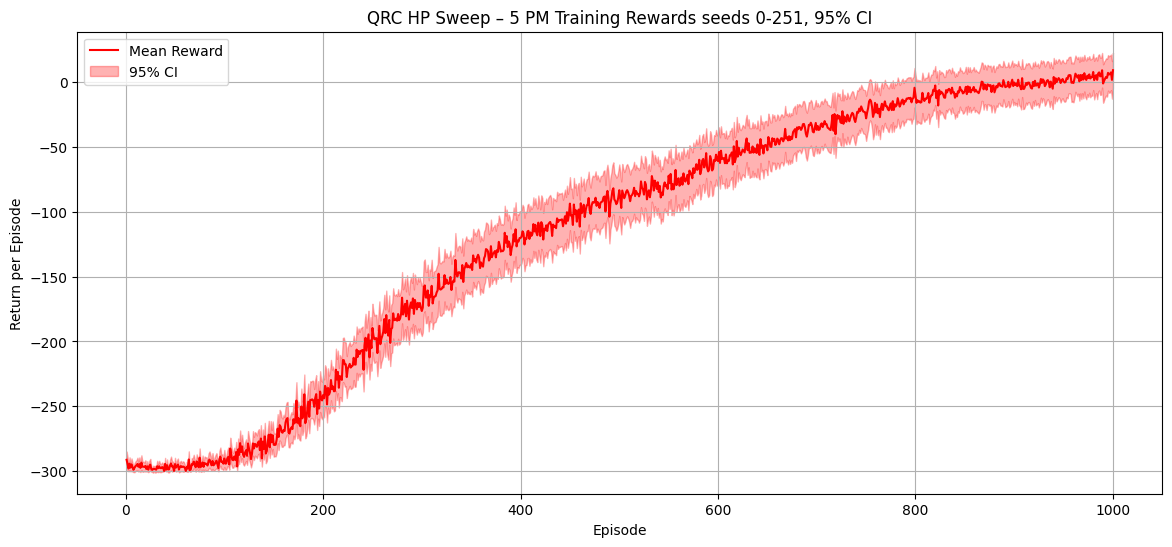

num_seeds : 251
num_episodes : 1000


/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)


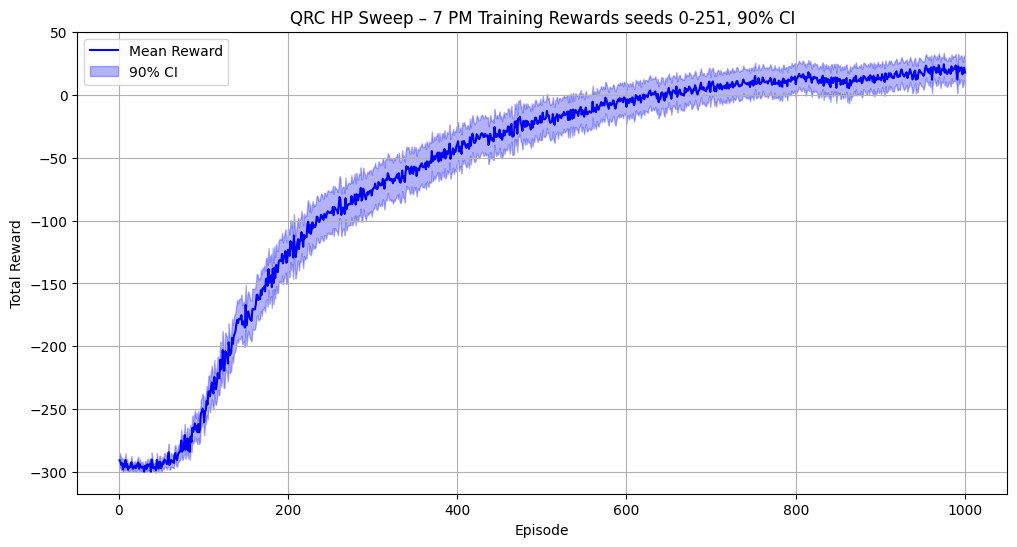

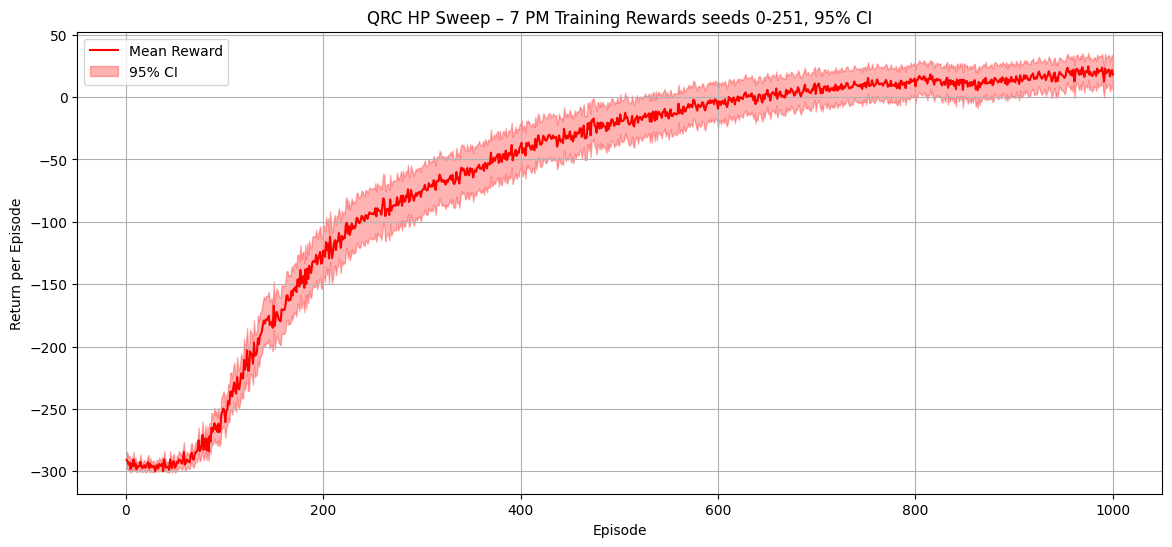

num_seeds : 251
num_episodes : 1000


/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)


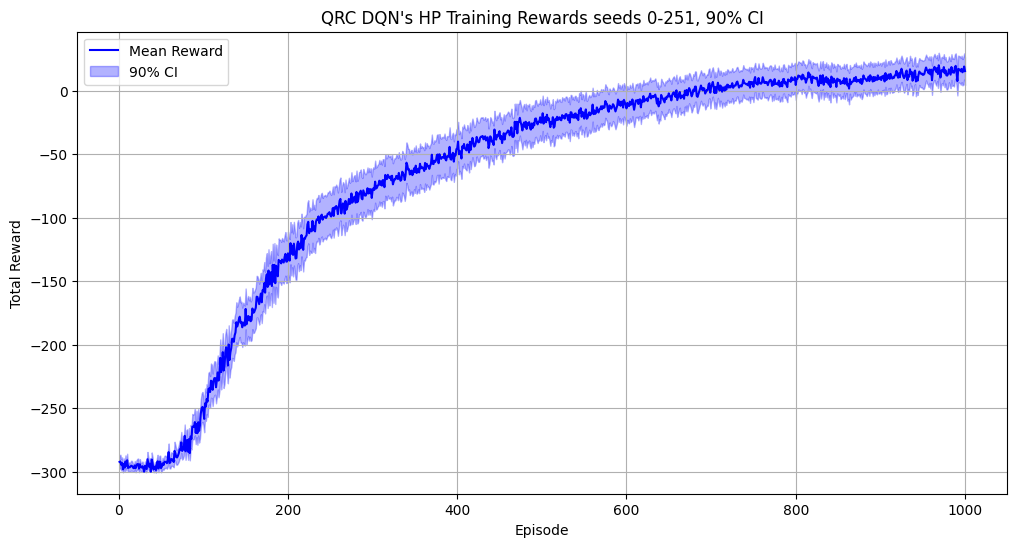

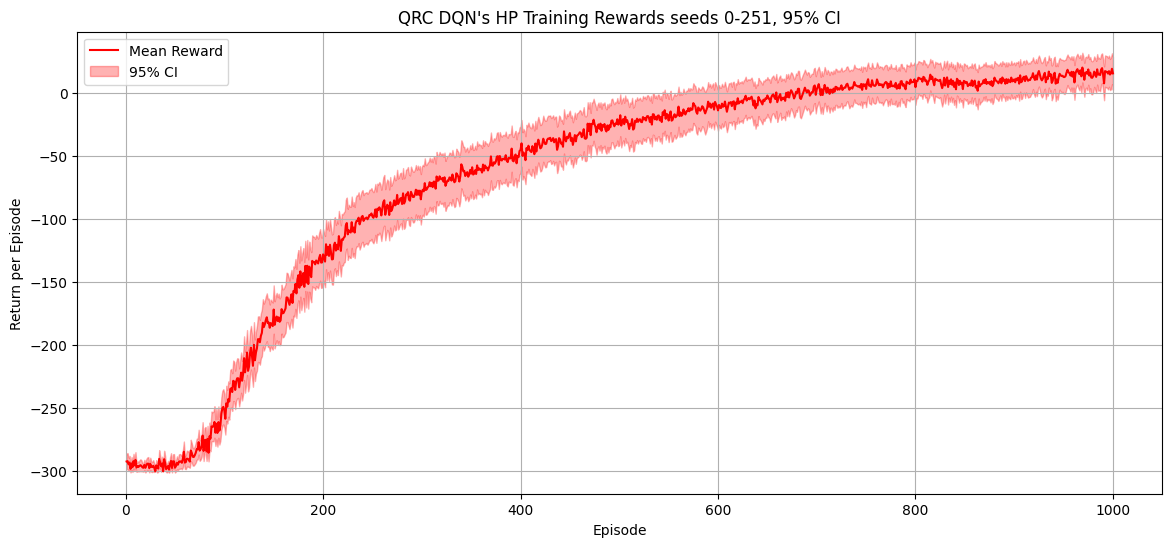

num_seeds : 251
num_episodes : 1000


/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)


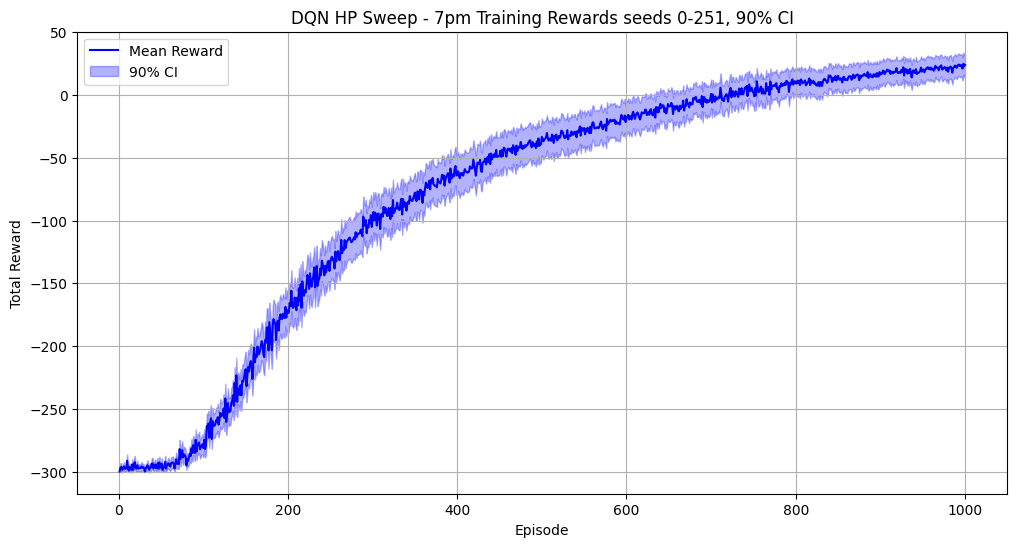

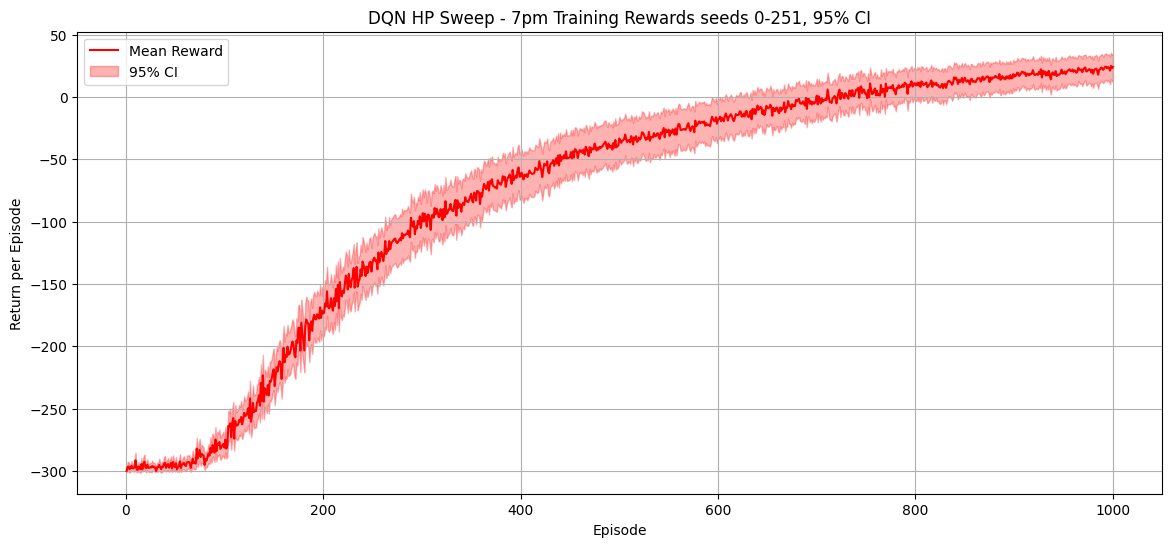

num_seeds : 251
num_episodes : 1000


/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)


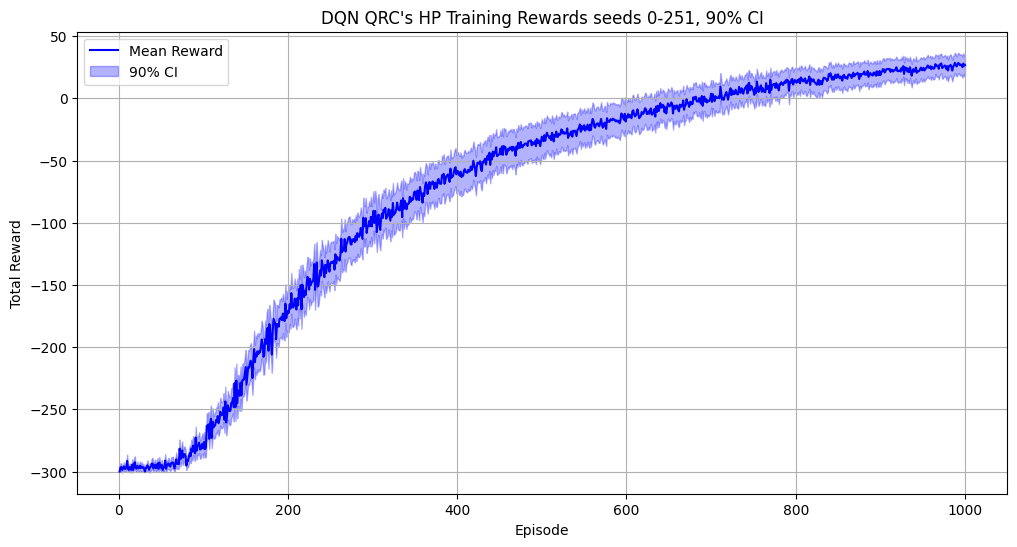

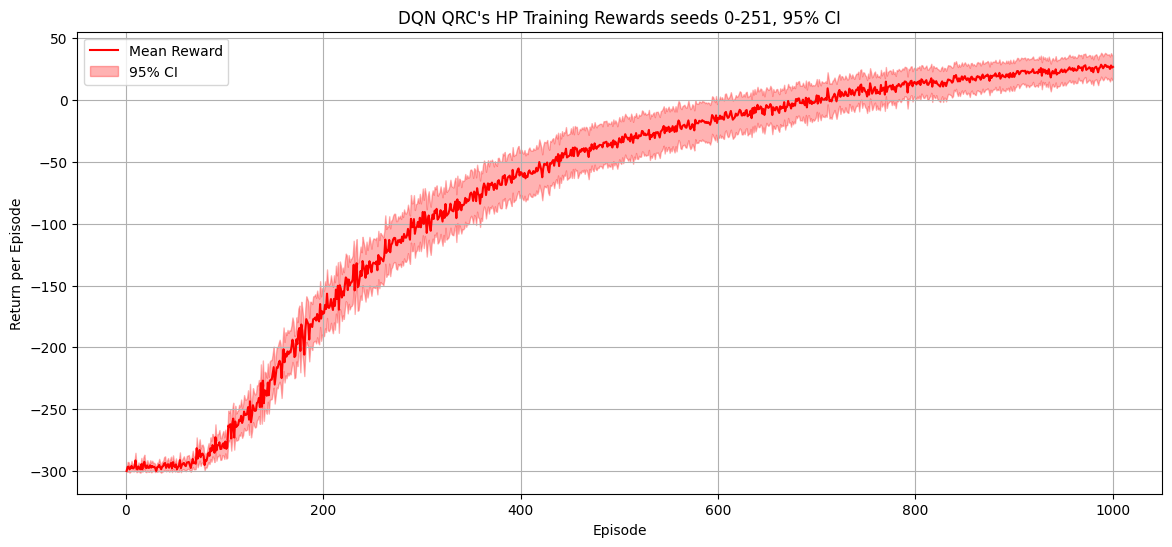

In [159]:
# plot_qrc_rewards(pt_file="../data/qrc_reward_seeds.pt", name="QRC Default")
# plot_qrc_rewards(pt_file="../data/dqn_reward_seeds.pt", name="DQN Default")

outputs = [
    "../data/qrc_results/qrc_baseline_mac.pt",
    "../data/qrc_results/qrc_baseline_cc.pt",
    "../data/qrc_results/qrc_hps_5pm.pt",
    "../data/qrc_results/qrc_best_hyperparameters.pt",
    "../data/qrc_results/qrc_with_dqn_hyperparameters.pt",
    "../data/dqn_results/best_hyperparameters.pt",
    "../data/dqn_results/dqn_with_qrc_hyperparameters.pt"
]

names = [
    "QRC Baseline (MacBook)",
    "QRC Baseline (Compute Canada)",
    "QRC HP Sweep – 5 PM",
    "QRC HP Sweep – 7 PM",
    "QRC DQN's HP",
    "DQN HP Sweep - 7pm",
    "DQN QRC's HP"
]

for index, item in enumerate(outputs):
    plot_qrc_rewards(pt_file=item, name=names[index])

QRC seeds : 183
DQN seeds : 251


/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rewards = np.array(data['rewards'])
/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rewards = np.array(data['rewards'])


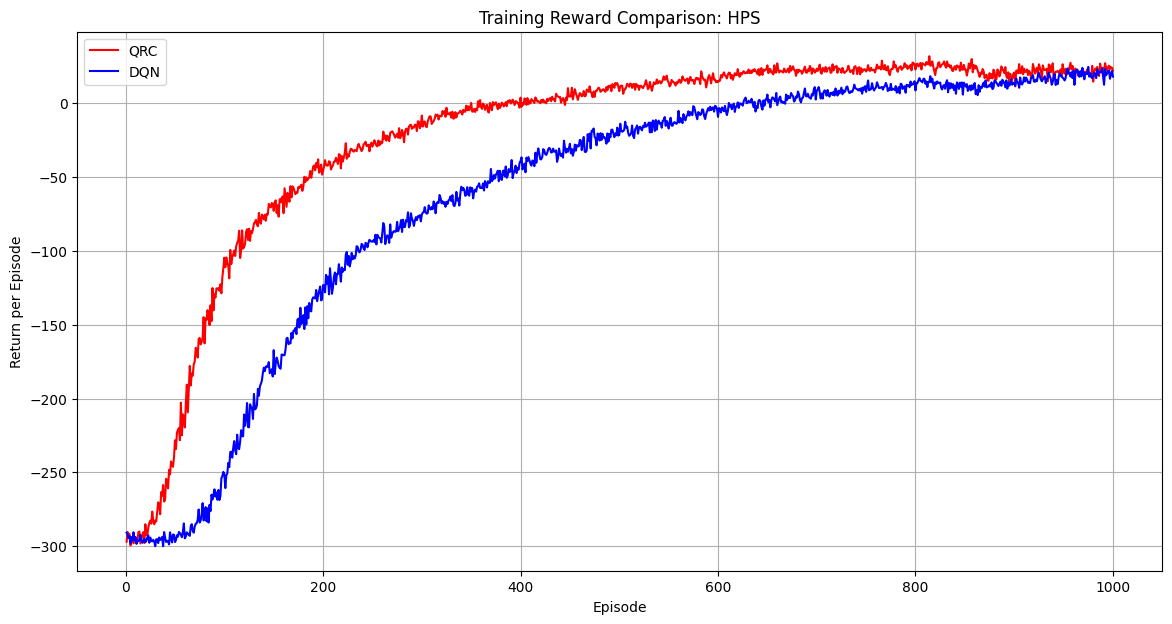

QRC seeds : 183
DQN seeds : 119


/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rewards = np.array(data['rewards'])
/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_96312/3154838346.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rewards = np.array(data['rewards'])


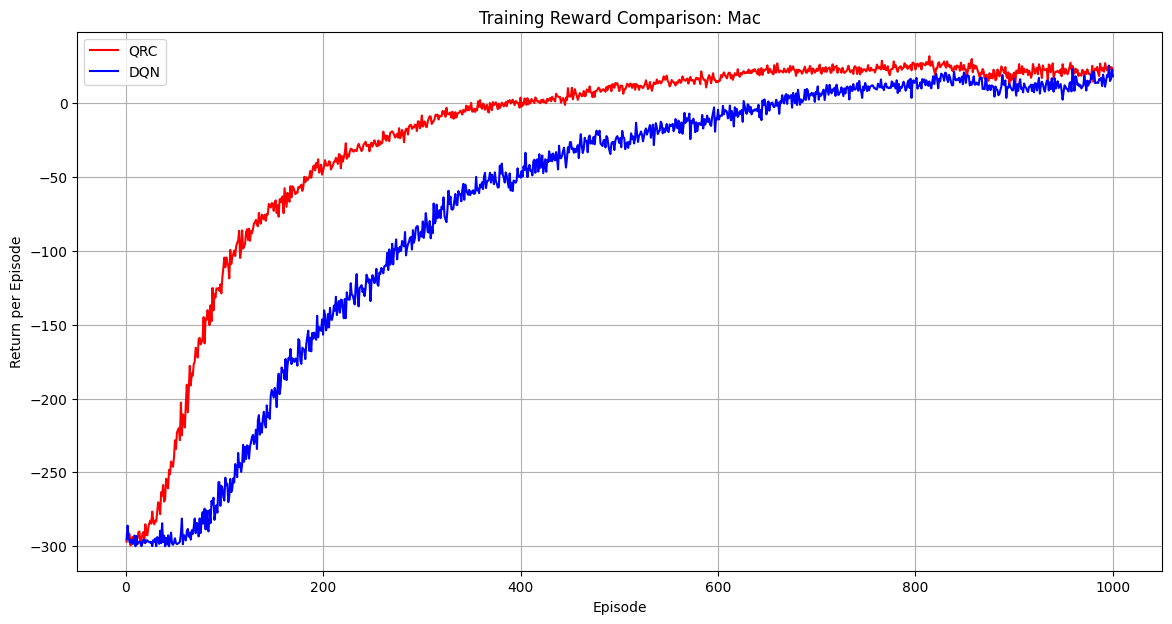

[QRC] Seeds: 251, Episodes: 1000
[No Target Network Update] Seeds: 251, Episodes: 1000
[With target network update] Seeds: 251, Episodes: 1000


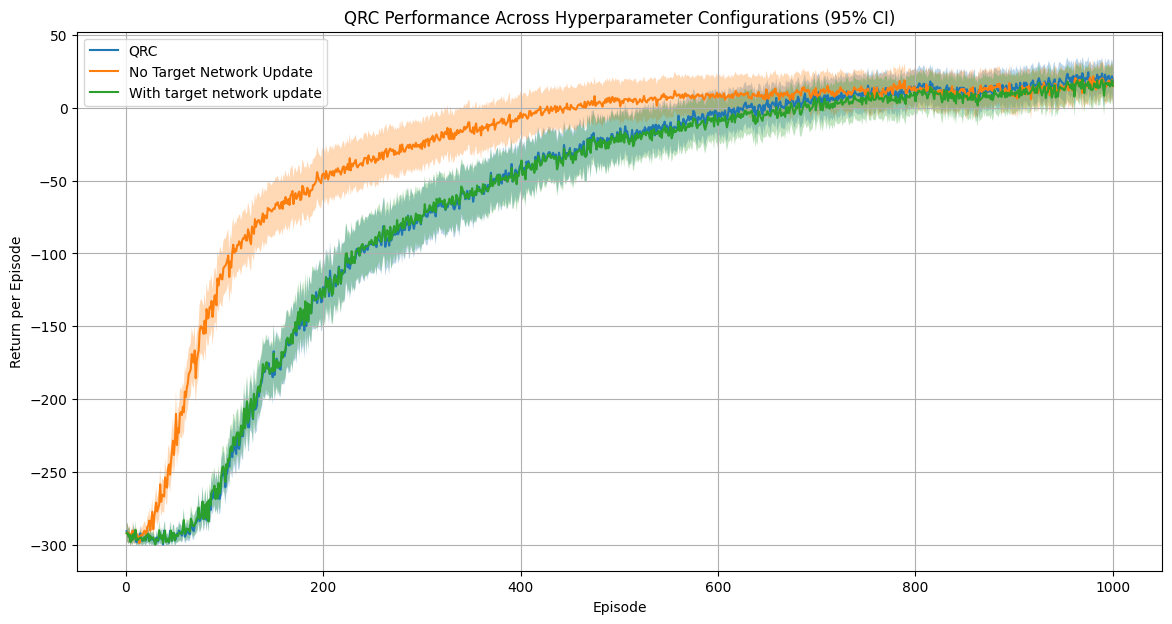

In [160]:
# plot_qrc_rewards(pt_file="../data/qrc_reward_seeds_hps.pt", name="QRC hps")
# plot_qrc_rewards(pt_file="../data/dqn_reward_seeds_target_update_2.pt", name="DQN Target Update 2")

plot_graph(
    qrc_file="../data/qrc_reward_seeds_ntu.pt",
    dqn_file="../data/qrc_results/qrc_best_hyperparameters.pt",
    graph_title="Training Reward Comparison: HPS"
)

plot_graph(
    qrc_file="../data/qrc_reward_seeds_ntu.pt",
    dqn_file="../data/qrc_reward_seeds_new.pt",
    graph_title="Training Reward Comparison: Mac"
)

folders = [
    "../data/qrc_results/best_hyperparameters",
    "../result_no_tnu",
    "../result_with_tnu"
]
names = [
    "QRC",
    "No Target Network Update",
    "With target network update",
]
plot_multiple_rewards(folders, names, ci=0.95, title="QRC Performance Across Hyperparameter Configurations")

[Baseline (MacBook)] Seeds: 250, Episodes: 1000
[Baseline (Compute Canada)] Seeds: 210, Episodes: 1000
[HP Sweep – 5 PM] Seeds: 251, Episodes: 1000
[HP Sweep – 7 PM] Seeds: 251, Episodes: 1000
[DQN's HP] Seeds: 251, Episodes: 1000


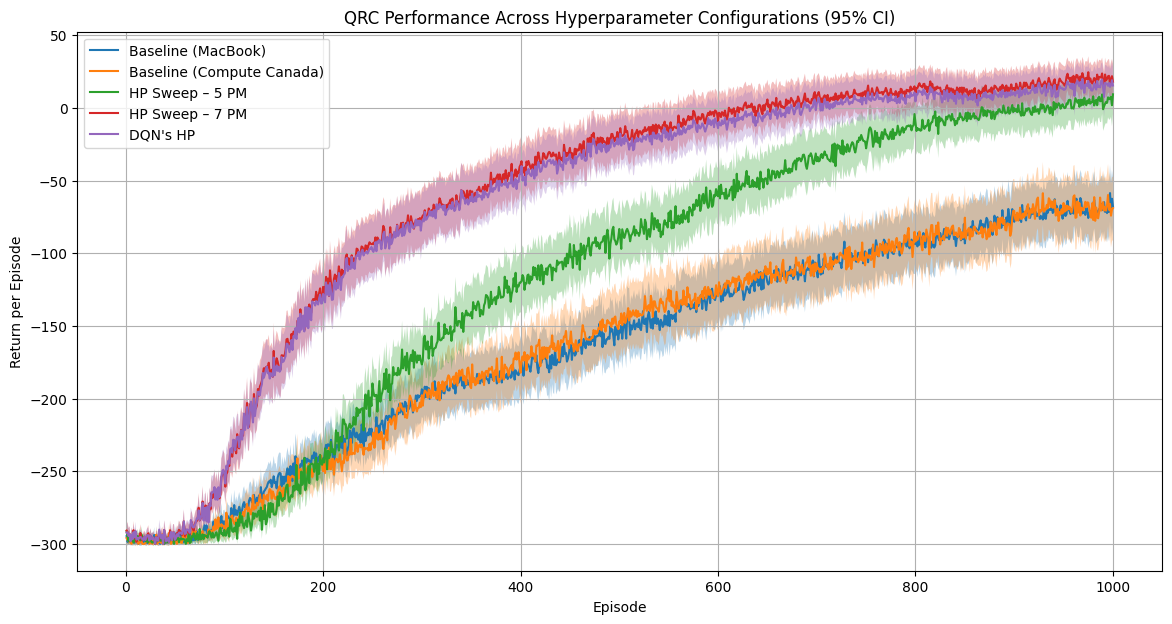

In [161]:
folders = [
    "../data/qrc_results/baseline_mac", 
    "../data/qrc_results/baseline_cc", 
    "../data/qrc_results/hps_5pm",
    "../data/qrc_results/best_hyperparameters",
    "../data/qrc_results/with_dqn_hyperparameters"
]
names = [
    "Baseline (MacBook)",
    "Baseline (Compute Canada)",
    "HP Sweep – 5 PM",
    "HP Sweep – 7 PM",
    "DQN's HP"
]
plot_multiple_rewards(folders, names, ci=0.95, title="QRC Performance Across Hyperparameter Configurations")

[QRC] Seeds: 251, Episodes: 1000
[DQN] Seeds: 251, Episodes: 1000
[QRC sub] Seeds: 251, Episodes: 1000
[DQN sub] Seeds: 251, Episodes: 1000


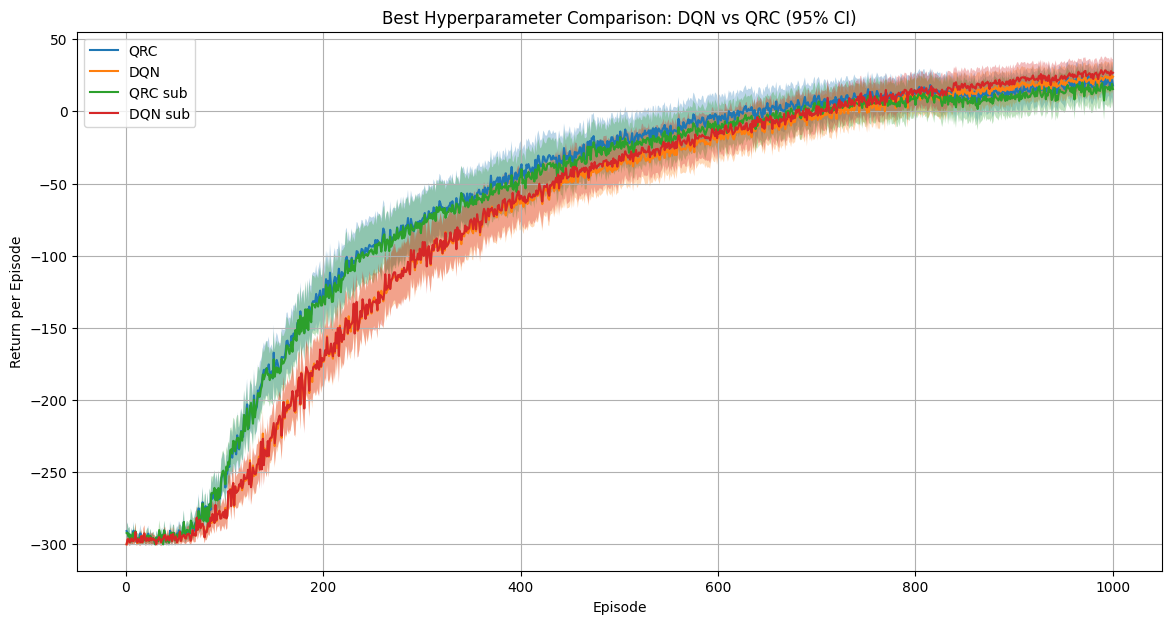

[QRC] Seeds: 251, Episodes: 1000
[DQN] Seeds: 251, Episodes: 1000
[QRC sub] Seeds: 251, Episodes: 1000
[DQN sub] Seeds: 251, Episodes: 1000


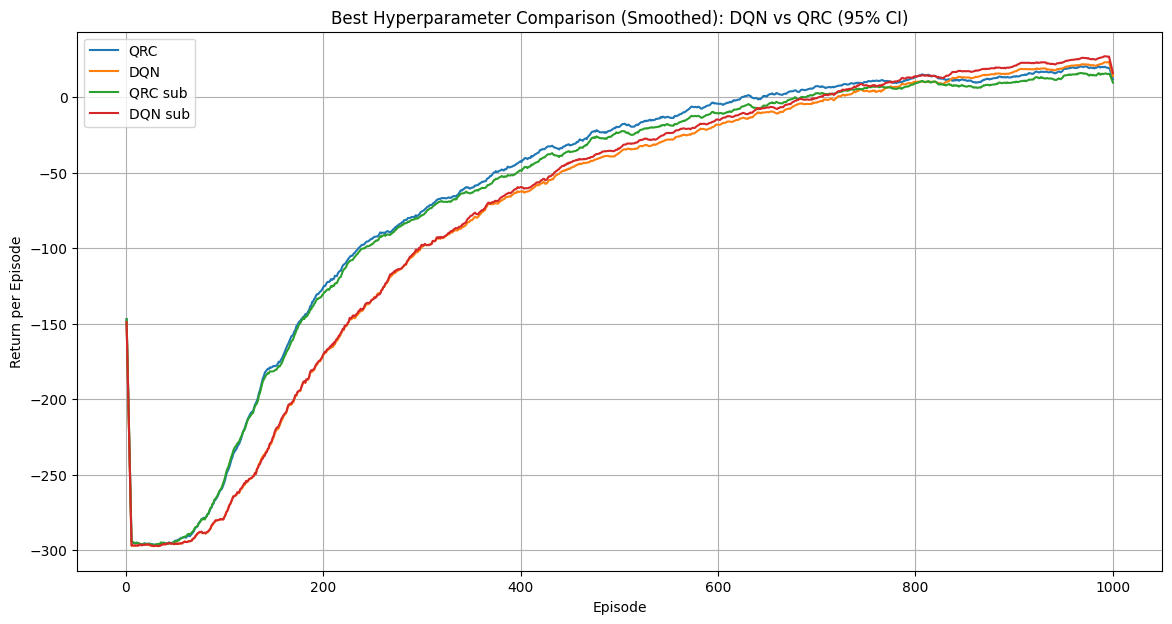

In [162]:
folders = [
    "../data/qrc_results/best_hyperparameters",
    "../data/dqn_results/best_hyperparameters",
    "../data/qrc_results/with_dqn_hyperparameters",
    "../data/dqn_results/with_qrc_hyperparameters",
]
names = [
    "QRC",
    "DQN",
    "QRC sub",
    "DQN sub"
]
plot_multiple_rewards(
    folders, 
    names, 
    ci=0.95, 
    title="Best Hyperparameter Comparison: DQN vs QRC"
)

plot_multiple_rewards_smooth(
    folders, 
    names, 
    ci=0.95, 
    title="Best Hyperparameter Comparison (Smoothed): DQN vs QRC"
)

[DQN] Seeds: 251, Episodes: 1000
[DQN sub] Seeds: 251, Episodes: 1000


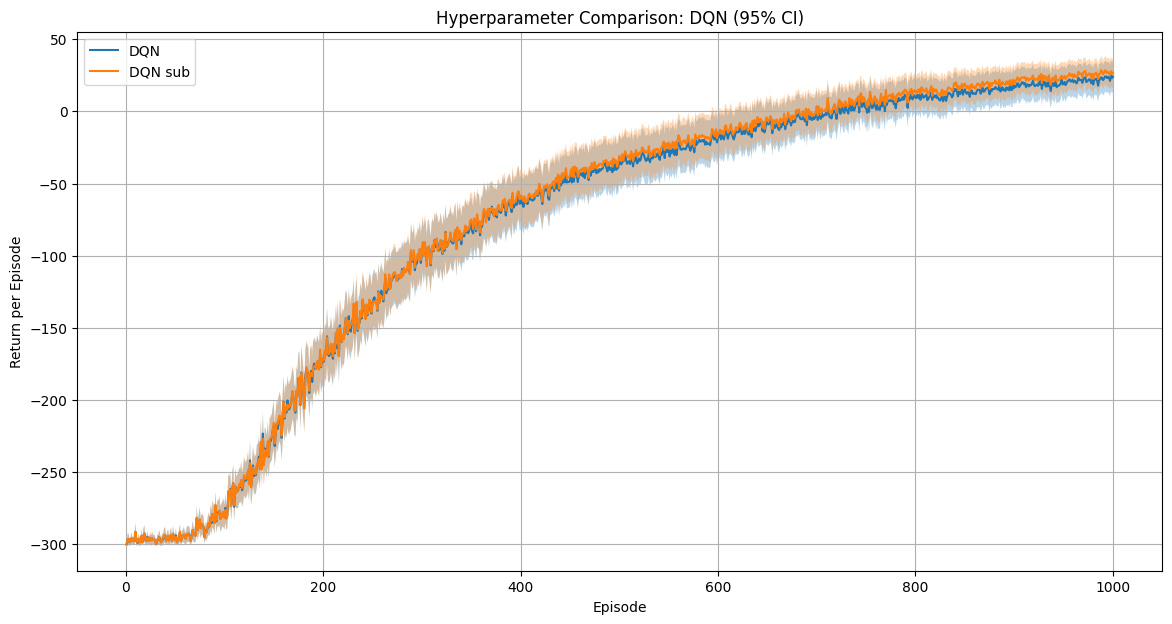

[DQN] Seeds: 251, Episodes: 1000
[DQN sub] Seeds: 251, Episodes: 1000


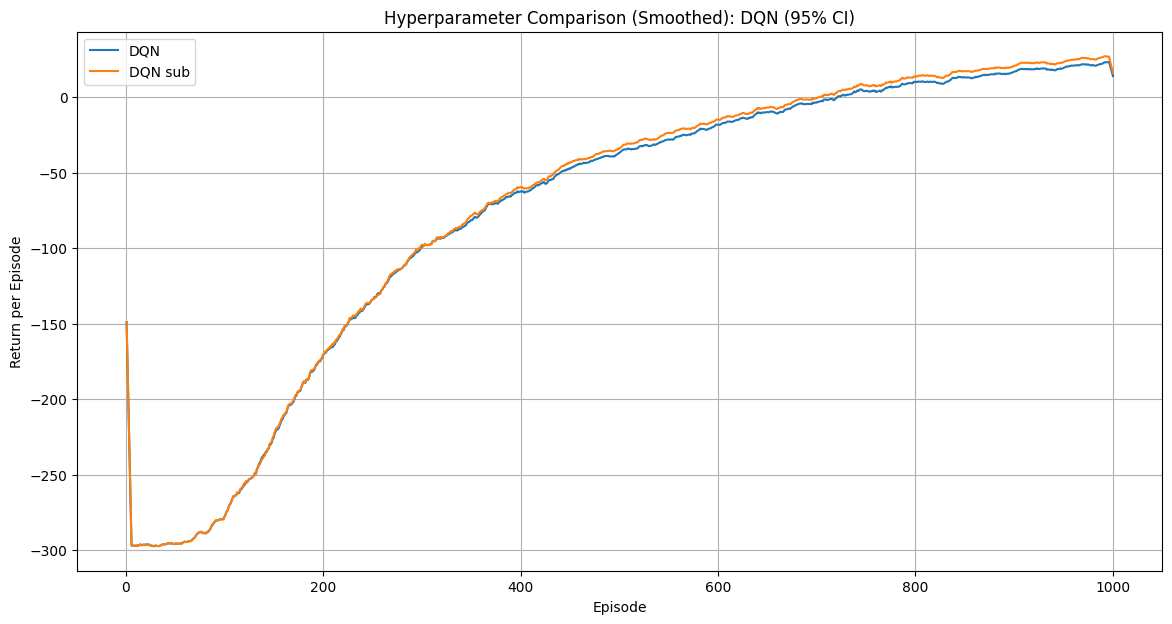

In [163]:
folders = [
    "../data/dqn_results/best_hyperparameters",
    "../data/dqn_results/with_qrc_hyperparameters",
]
names = [
    "DQN",
    "DQN sub"
]
plot_multiple_rewards(
    folders, 
    names, 
    ci=0.95, 
    title="Hyperparameter Comparison: DQN"
)

plot_multiple_rewards_smooth(
    folders, 
    names, 
    ci=0.95, 
    title="Hyperparameter Comparison (Smoothed): DQN"
)

[QRC] Seeds: 251, Episodes: 1000
[QRC sub] Seeds: 251, Episodes: 1000


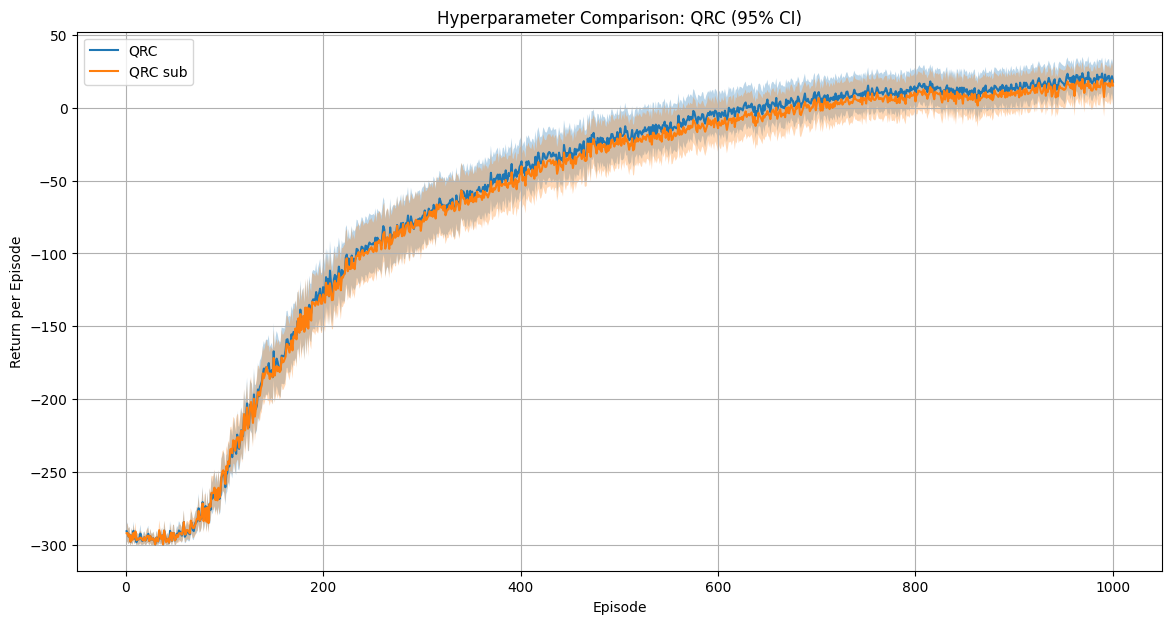

[QRC] Seeds: 251, Episodes: 1000
[QRC sub] Seeds: 251, Episodes: 1000


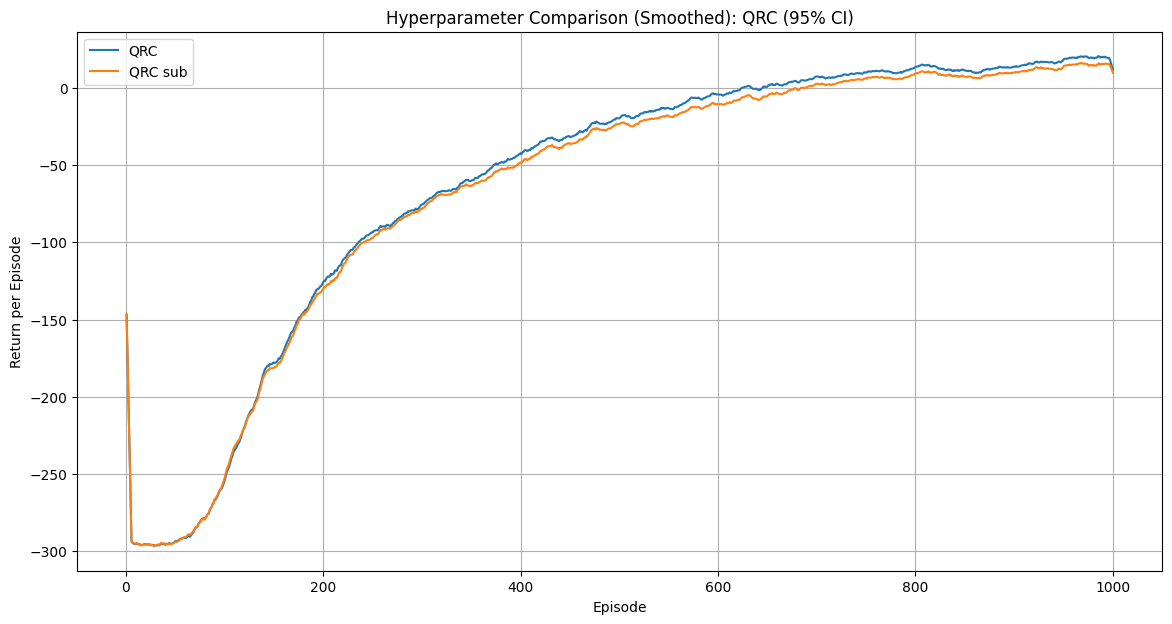

In [164]:
folders = [
    "../data/qrc_results/best_hyperparameters",
    "../data/qrc_results/with_dqn_hyperparameters"
]
names = [
    "QRC",
    "QRC sub"
]
plot_multiple_rewards(
    folders, 
    names, 
    ci=0.95, 
    title="Hyperparameter Comparison: QRC"
)

plot_multiple_rewards_smooth(
    folders, 
    names, 
    ci=0.95, 
    title="Hyperparameter Comparison (Smoothed): QRC"
)

[QRC] Seeds: 251, Episodes: 1000
[DQN] Seeds: 251, Episodes: 1000


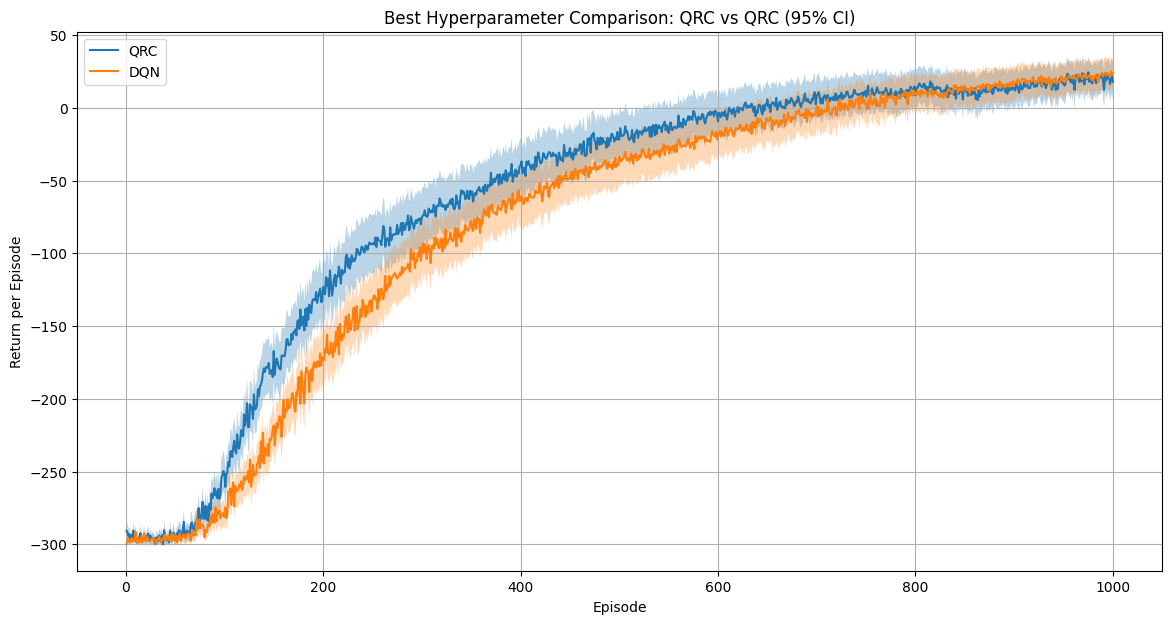

[QRC] Seeds: 251, Episodes: 1000
[DQN] Seeds: 251, Episodes: 1000


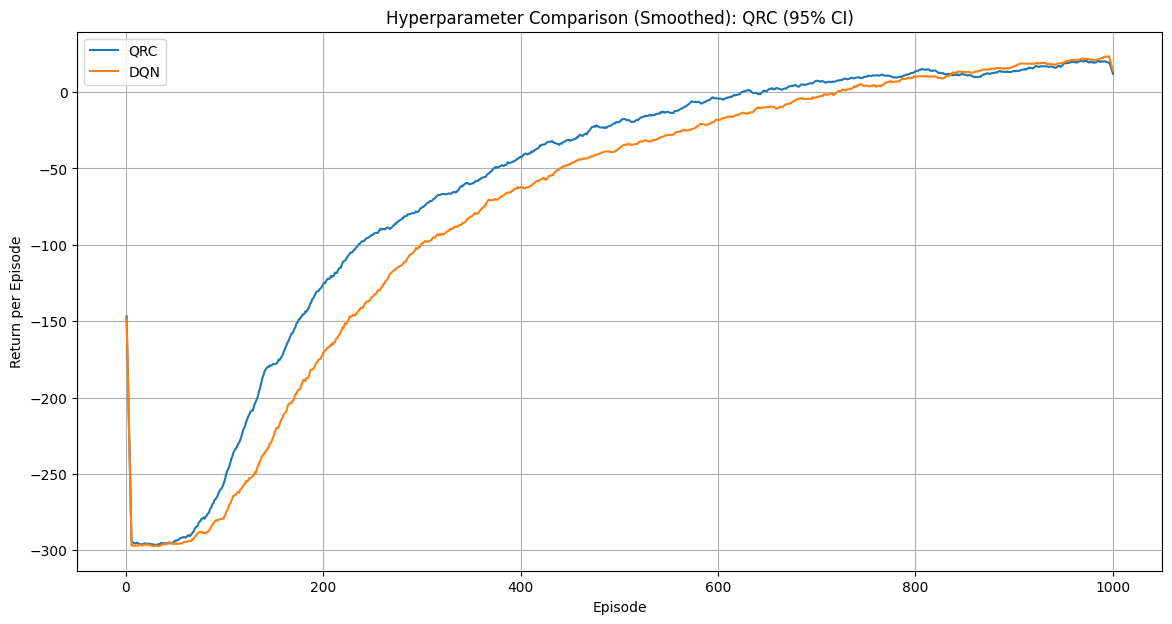

In [165]:
folders = [
    "../data/qrc_results/best_hyperparameters",
    "../data/dqn_results/best_hyperparameters"
]
names = [
    "QRC",
    "DQN"
]
plot_multiple_rewards(
    folders, 
    names, 
    ci=0.95, 
    title="Best Hyperparameter Comparison: QRC vs QRC"
)

plot_multiple_rewards_smooth(
    folders, 
    names, 
    ci=0.95, 
    title="Hyperparameter Comparison (Smoothed): QRC"
)

In [166]:
# folder = "../results_hps_7pm"
# expected = set(range(251))  # seeds 0 to 251 inclusive

# # Get actual seeds from filenames
# actual = set()

# for filename in os.listdir(folder):
#     if filename.startswith("qrc_seed_") and filename.endswith(".txt"):
#         try:
#             seed = int(filename[len("qrc_seed_"):-4])
#             actual.add(seed)
#         except ValueError:
#             pass

# # Compute missing seeds
# missing = sorted(expected - actual)

# print("Missing seeds:", missing)
# print("Number of missing files:", len(missing))

In [167]:
# def save_rewards_to_pt(folder_path, output_file):
#     all_rewards = []

#     # List all txt files in the folder
#     txt_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".txt")])
#     if not txt_files:
#         print(f"No .txt files found in {folder_path}")
#         return

#     for f in txt_files:
#         file_path = os.path.join(folder_path, f)
#         rewards = np.loadtxt(file_path)
#         all_rewards.append(rewards)

#     all_rewards = np.stack(all_rewards)  # shape = (num_files, num_episodes)

#     # Save as .pt
#     torch.save(
#         {"rewards": torch.tensor(all_rewards, dtype=torch.float32)},
#         output_file
#     )
#     print(f"Saved rewards from {len(txt_files)} files to {output_file}")


# folders = [
#     "../data/qrc_results/baseline_mac",
#     "../data/qrc_results/baseline_cc",
#     "../data/qrc_results/hps_5pm",
#     "../data/qrc_results/best_hyperparameters",
#     "../data/qrc_results/with_dqn_hyperparameters",
#     "../data/dqn_results/best_hyperparameters",
#     "../data/dqn_results/with_qrc_hyperparameters",
# ]

# outputs = [
#     "../data/qrc_results/qrc_baseline_mac.pt",
#     "../data/qrc_results/qrc_baseline_cc.pt",
#     "../data/qrc_results/qrc_hps_5pm.pt",
#     "../data/qrc_results/qrc_best_hyperparameters.pt",
#     "../data/qrc_results/qrc_with_dqn_hyperparameters.pt",
#     "../data/dqn_results/best_hyperparameters.pt",
#     "../data/dqn_results/dqn_with_qrc_hyperparameters.pt"
# ]

# for folder, out_file in zip(folders, outputs):
#     save_rewards_to_pt(folder, out_file)